In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import lightgbm as lgb

import pickle

In [2]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import mean_squared_error
# from sklearn.datasets import load_diabetes

Using TensorFlow backend.


In [3]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'

In [4]:
PROCESSED_TRAIN = '20190618_dist_bond_cos3j_train.pickle'
# MODEL = '20190621_champs_models_lgb.pickle'

In [5]:
# df_train= pd.read_pickle(OUTPUT + PROCESSED_TRAIN)
bond_types = ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']

In [6]:
def type_score(y_val, y_pred):
    return np.log(sum(np.abs(y_val- y_pred)) / len(y_val))

In [25]:
def reg_model():
    model = Sequential()
    model.add(Dense(64, input_dim=145, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1))

    # compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [26]:
models = []
scores = np.zeros([0])
pickups_train = []
pickups_val = []
for i, b in enumerate(bond_types):
    df_bond = pd.read_csv(OUTPUT + '20190628_dist_bond_dir_cos3j_train_{}.csv'.format(b))
    mols = df_bond['molecule_name'].unique()
    num = len(mols)
    num_train = int(num * 0.8)
    pickup = random.sample(range(num), num)
    pick_train = pickup[:num_train]
    pick_val = pickup[num_train:]
    pickups_train.append(pick_train)
    pickups_val.append(pick_val)
    
    df_train = df_bond[df_bond['molecule_name'].isin(mols[pick_train])]
    y_train = df_train['scalar_coupling_constant'].values
    X_train = df_train[df_train.columns[6:]].values
    
    df_val = df_bond[df_bond['molecule_name'].isin(mols[pick_val])]
    y_val = df_val['scalar_coupling_constant'].values
    X_val = df_val[df_val.columns[6:]].values
    
#     model = reg_model()
    
    model = KerasRegressor(build_fn=reg_model, epochs=10, batch_size=64, validation_data=(X_val,y_val))
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    
    score = type_score(y_val, y_pred)
    scores = np.hstack([scores, score])
    models.append(model)

Train on 567346 samples, validate on 142070 samples
Epoch 1/10
567346/567346 [==============================] - 45s 78us/step - loss: 1212.3871 - val_loss: 330.1601
Epoch 2/10
567346/567346 [==============================] - 44s 77us/step - loss: 335.1236 - val_loss: 330.3973
Epoch 3/10
567346/567346 [==============================] - 44s 78us/step - loss: 335.1363 - val_loss: 330.1547
Epoch 4/10
567346/567346 [==============================] - 44s 78us/step - loss: 335.1227 - val_loss: 330.1511
Epoch 5/10
567346/567346 [==============================] - 44s 78us/step - loss: 335.1364 - val_loss: 330.2053
Epoch 6/10
567346/567346 [==============================] - 44s 77us/step - loss: 335.1181 - val_loss: 330.3770
Epoch 7/10
567346/567346 [==============================] - 44s 78us/step - loss: 335.1194 - val_loss: 330.1768
Epoch 8/10
567346/567346 [==============================] - 44s 78us/step - loss: 335.1265 - val_loss: 330.2935
Epoch 9/10
567346/567346 [=========================

KeyboardInterrupt: 

In [ ]:
print('type score:', scores)
print('total score:', scores.mean())

# type score: [-0.4735228  -1.70507637 -1.02514106 -1.60275171 -1.13635603 -0.37426881
#  -0.40711649 -1.69301447]
# total score: -1.0521559664830797


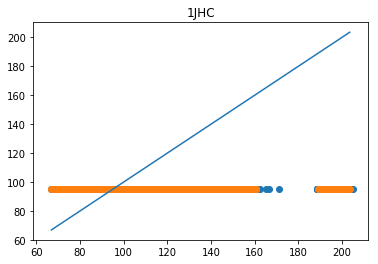

IndexError: list index out of range

In [27]:
for i, b in enumerate(bond_types):
    df_bond = pd.read_csv(OUTPUT + '20190628_dist_bond_dir_cos3j_train_{}.csv'.format(b))
    mols = df_bond['molecule_name'].unique()
    
    pick_train = pickups_train[i]
    pick_val = pickups_val[i]
    
    df_train = df_bond[df_bond['molecule_name'].isin(mols[pick_train])]
    y_train = df_train['scalar_coupling_constant'].values
    X_train = df_train[df_train.columns[6:]].values
    
    df_val = df_bond[df_bond['molecule_name'].isin(mols[pick_val])]
    y_val = df_val['scalar_coupling_constant'].values
    X_val = df_val[df_val.columns[6:]].values

    model = models[i]
    
    y_pred = model.predict(X_val)
    y_pred_train = model.predict(X_train)
    plt.scatter(y_train, y_pred_train)
    plt.scatter(y_val, y_pred)
    plt.title('{}'.format(b))
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()])
    plt.show()

In [ ]:
# with open(OUTPUT + MODEL, 'wb') as f:
#     pickle.dump(models, f)